# Are all Highs the same, regardless of the low? 

files: same High gain, but different Low gains. 


📊 FITS File Statistics:

+-------------------------------------------------------------------------+-------+--------+--------+-------+
| File                                                                    |   Max |   Mean |    RMS |   Std |
+=========================================================================+=======+========+========+=======+
| area92_g_low14_high16.5_2025_10_08_2x2_exp00.00.20.000_000001_Low_1.fit |  3786 | 527.8  | 528.52 | 27.5  |
+-------------------------------------------------------------------------+-------+--------+--------+-------+
| area92_g_low14_high13.5_2025_10_08_2x2_exp00.00.20.000_000001_Low_1.fit |  3789 | 527.53 | 528.26 | 27.73 |
+-------------------------------------------------------------------------+-------+--------+--------+-------+


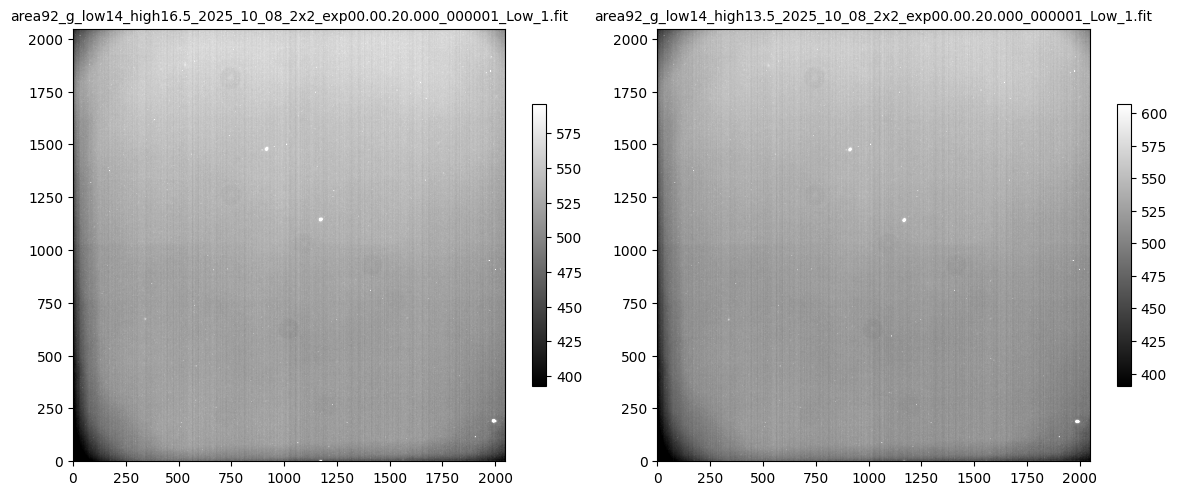

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os
from astropy.visualization import ZScaleInterval
import pandas as pd
from tabulate import tabulate  # Make sure this is installed: pip install tabulate

# --- INSERT YOUR FILE PATHS HERE ---
file_paths = [
    r"C:\Users\AYSAN\Desktop\project\INO\ETC\Highs and Lows\g\area92_g_low14_high16.5_2025_10_08_2x2_exp00.00.20.000_000001_Low_1.fit",
    r"C:\Users\AYSAN\Desktop\project\INO\ETC\Highs and Lows\g\area92_g_low14_high13.5_2025_10_08_2x2_exp00.00.20.000_000001_Low_1.fit"
]

# --- LOAD DATA ---
data_list = []
for path in file_paths:
    with fits.open(path) as hdul:
        data = hdul[0].data.astype(np.float32)
        data_list.append((path, data))

# --- STATISTICS FUNCTION ---
def compute_stats(data):
    return {
        'Max': np.max(data),
        'Mean': np.mean(data),
        'RMS': np.sqrt(np.mean(data**2)),
        'Std': np.std(data)
    }

# --- BUILD TABLE ---
table_rows = []
for path, data in data_list:
    stats = compute_stats(data)
    table_rows.append({
        'File': os.path.basename(path),
        'Max': round(stats['Max'], 2),
        'Mean': round(stats['Mean'], 2),
        'RMS': round(stats['RMS'], 2),
        'Std': round(stats['Std'], 2)
    })

df = pd.DataFrame(table_rows)

# --- PRETTY PRINT TABLE ---
print("\n📊 FITS File Statistics:\n")
print(tabulate(df, headers='keys', tablefmt='grid', showindex=False))

# --- VISUAL COMPARISON WITH ZSCALE AND 2x2 GRID ---
zscale = ZScaleInterval()
n = len(data_list)
cols = 2
rows = (n + 1) // 2  # ensures 2x2 layout for up to 4 files

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
axes = axes.flatten()

for i, (path, data) in enumerate(data_list):
    vmin, vmax = zscale.get_limits(data)
    im = axes[i].imshow(data, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
    axes[i].set_title(os.path.basename(path), fontsize=10)
    plt.colorbar(im, ax=axes[i], shrink=0.6)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


C:\Users\AYSAN\AppData\Local\Temp\ipykernel_13848\3628112911.py:46: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
C:\Users\AYSAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


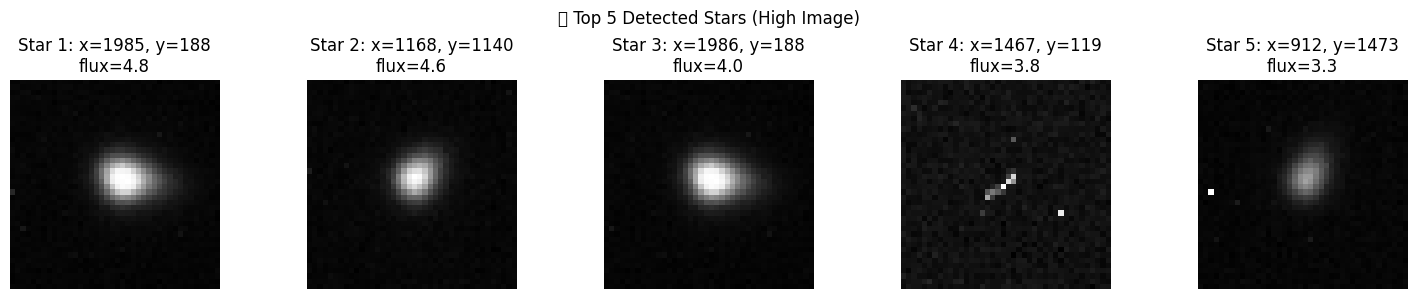

Selected stars for next steps:
Star 1: x=1985, y=188
Star 2: x=1168, y=1140
Star 3: x=1986, y=188
Star 4: x=912, y=1473
Gain Comparison:
High Image GAIN = 16.5
Low Image GAIN  = 2.8
GAIN Ratio (High / Low) = 5.893
Intensity Ratios (High / Low):
Star 1: x=1985, y=188 | I_high=1627730.00 | I_low=212471.00 | Ratio=7.661
Star 2: x=1168, y=1140 | I_high=1697885.00 | I_low=215140.00 | Ratio=7.892
Star 3: x=1986, y=188 | I_high=1626962.00 | I_low=212466.00 | Ratio=7.658
Star 4: x=912, y=1473 | I_high=1623298.00 | I_low=216330.00 | Ratio=7.504
Background Analysis: 10 regions
Region 1: x=1750, y=670 | Ratio=7.377
Region 2: x=1483, y=38 | Ratio=7.057
Region 3: x=688, y=465 | Ratio=7.371
Region 4: x=1165, y=1703 | Ratio=7.251
Region 5: x=1566, y=735 | Ratio=7.404
Region 6: x=1621, y=87 | Ratio=7.197
Region 7: x=450, y=725 | Ratio=7.297
Region 8: x=1089, y=983 | Ratio=7.509
Region 9: x=1803, y=1754 | Ratio=7.073
Region 10: x=1428, y=1527 | Ratio=7.326
Photometric Ratio Summary:

+---------------+-

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.stats import mad_std
from photutils.detection import DAOStarFinder
from astropy.modeling import models, fitting
from tabulate import tabulate
import random
import os

# --- File paths ---
high_path = r"C:\Users\AYSAN\Desktop\project\INO\ETC\Highs and Lows\g\area92_g_low2.8_high16.5_2025_10_08_2x2_exp00.00.10.000_000001_High_1.fit"
low_path  = r"C:\Users\AYSAN\Desktop\project\INO\ETC\Highs and Lows\g\area92_g_low2.8_high16.5_2025_10_08_2x2_exp00.00.10.000_000001_Low_1.fit"

# --- Load FITS data ---
with fits.open(high_path) as hdul_high:
    high_data = hdul_high[0].data.astype(np.float32)
    gain_high = hdul_high[0].header.get('GAIN', np.nan)

with fits.open(low_path) as hdul_low:
    low_data = hdul_low[0].data.astype(np.float32)
    gain_low = hdul_low[0].header.get('GAIN', np.nan)

gain_ratio = gain_high / gain_low if gain_low != 0 else np.nan


# --- Star detection ---
bkg_sigma = mad_std(high_data)
daofind = DAOStarFinder(fwhm=3.0, threshold=5.0 * bkg_sigma)
sources = daofind(high_data)
sources.sort('flux')
top_sources = sources[::-1][:5]

# --- Visualize top detected stars ---
plt.figure(figsize=(15, 3))
for i, star in enumerate(top_sources[:5], 1):
    x, y = int(star['xcentroid']), int(star['ycentroid'])
    cutout = high_data[y-20:y+20, x-20:x+20]

    plt.subplot(1, 5, i)
    plt.imshow(cutout, cmap='gray', origin='lower')
    plt.title(f"Star {i}: x={x}, y={y}\nflux={star['flux']:.1f}")
    plt.axis('off')

plt.suptitle("🔍 Top 5 Detected Stars (High Image)")
plt.tight_layout()
plt.show()


# --- Manual star selection ---
selected_indices = [1, 2, 3, 5] 
selected_stars = [top_sources[i - 1] for i in selected_indices]
selected_coords = [(int(star['xcentroid']), int(star['ycentroid'])) for star in selected_stars]

print("Selected stars for next steps:")
for i, (x, y) in enumerate(selected_coords, 1):
    print(f"Star {i}: x={x}, y={y}")

print("Gain Comparison:")
print(f"High Image GAIN = {gain_high}")
print(f"Low Image GAIN  = {gain_low}")
print(f"GAIN Ratio (High / Low) = {gain_ratio:.3f}")


# --- Star intensity ratios ---
box_size = 20
ratios = []

for i, (x, y) in enumerate(selected_coords, 1):
    high_cutout = high_data[y-box_size:y+box_size, x-box_size:x+box_size]
    low_cutout  = low_data[y-box_size:y+box_size, x-box_size:x+box_size]

    if high_cutout.shape != (2*box_size, 2*box_size) or low_cutout.shape != (2*box_size, 2*box_size):
        print(f"Star {i}: cutout near edge — skipped")
        continue

    I_high = np.sum(high_cutout)
    I_low  = np.sum(low_cutout)
    ratio  = I_high / I_low if I_low != 0 else np.nan
    ratios.append((i, x, y, I_high, I_low, ratio))

print("Intensity Ratios (High / Low):")
for i, x, y, I_high, I_low, ratio in ratios:
    print(f"Star {i}: x={x}, y={y} | I_high={I_high:.2f} | I_low={I_low:.2f} | Ratio={ratio:.3f}")

# --- Background sampling ---
num_regions = 10
image_shape = high_data.shape
margin = box_size + 5
star_coords = set((int(x), int(y)) for x, y in selected_coords)

def is_far_from_stars(x, y, min_dist=2*box_size):
    for sx, sy in star_coords:
        if np.hypot(x - sx, y - sy) < min_dist:
            return False
    return True

bg_ratios = []
bg_locations = []
attempts = 0

while len(bg_ratios) < num_regions and attempts < 1000:
    x = random.randint(margin, image_shape[1] - margin)
    y = random.randint(margin, image_shape[0] - margin)
    attempts += 1

    if not is_far_from_stars(x, y):
        continue

    high_cutout = high_data[y-box_size:y+box_size, x-box_size:x+box_size]
    low_cutout  = low_data[y-box_size:y+box_size, x-box_size:x+box_size]

    if high_cutout.shape != (2*box_size, 2*box_size) or low_cutout.shape != (2*box_size, 2*box_size):
        continue

    if np.max(high_cutout) > np.median(high_cutout) + 5 * np.std(high_cutout):
        continue
    if np.std(high_cutout) > 2 * np.median(np.std(high_data)):
        continue

    I_high = np.sum(high_cutout)
    I_low  = np.sum(low_cutout)
    ratio  = I_high / I_low if I_low != 0 else np.nan

    bg_ratios.append(ratio)
    bg_locations.append((x, y))

print(f"Background Analysis: {len(bg_ratios)} regions")
for i, ((x, y), ratio) in enumerate(zip(bg_locations, bg_ratios), 1):
    print(f"Region {i}: x={x}, y={y} | Ratio={ratio:.3f}")

# --- Summary table ---
star_ratios = [r for (_, _, _, _, _, r) in ratios]
star_mean   = np.nanmean(star_ratios)
star_median = np.nanmedian(star_ratios)
star_std    = np.nanstd(star_ratios)

bg_mean     = np.nanmean(bg_ratios)
bg_median   = np.nanmedian(bg_ratios)
bg_std      = np.nanstd(bg_ratios)

summary_table = [
    ["Region Type", "Mean Ratio", "Median Ratio", "Std Dev"],
    ["Stars",       round(star_mean, 3), round(star_median, 3), round(star_std, 3)],
    ["Background",  round(bg_mean, 3),   round(bg_median, 3),   round(bg_std, 3)]
]

print("Photometric Ratio Summary:\n")
print(tabulate(summary_table[1:], headers=summary_table[0], tablefmt="grid"))


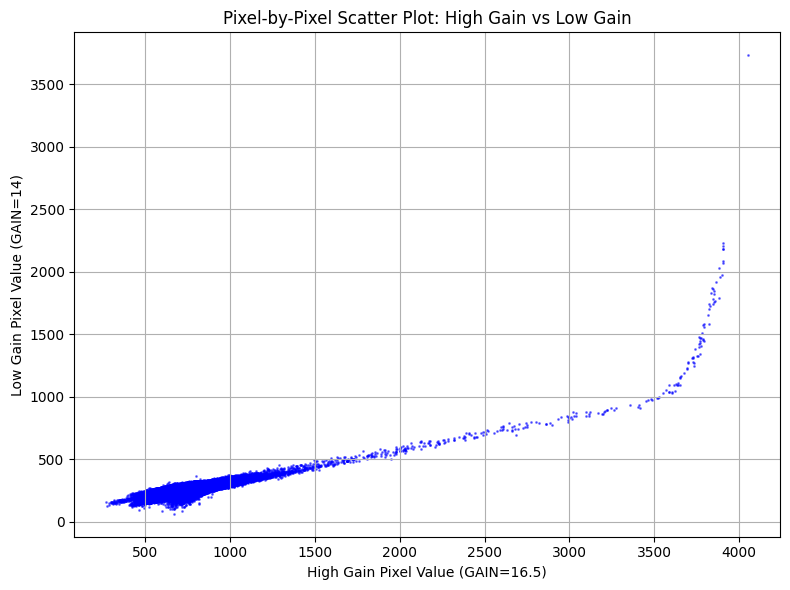

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits


# Read data and headers from FITS files


# Extract gain values
high_gain_value = high_header.get('GAIN', 'Unknown')
low_gain_value = low_header.get('GAIN', 'Unknown')

# Flatten the arrays
high_flat = high_data.flatten()
low_flat = low_data.flatten()

# Filter out invalid values (e.g., NaNs, infs)
mask = np.isfinite(high_flat) & np.isfinite(low_flat)
high_valid = high_flat[mask]
low_valid = low_flat[mask]

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(high_valid, low_valid, s=1, alpha=0.5, color='blue')
plt.xlabel(f'High Gain Pixel Value (GAIN={high_gain_value})')
plt.ylabel(f'Low Gain Pixel Value (GAIN={low_gain_value})')
plt.title('Pixel-by-Pixel Scatter Plot: High Gain vs Low Gain')
plt.grid(True)
plt.tight_layout()
plt.show()


In [35]:
import numpy as np
from astropy.io import fits
import random

# --- File paths ---
high_path = r"C:\Users\AYSAN\Desktop\project\INO\ETC\Highs and Lows\u\area92_u_low14_high13.5_2025_10_08_2x2_exp00.02.00.000_000001_High_1.fit"
low_path  = r"C:\Users\AYSAN\Desktop\project\INO\ETC\Highs and Lows\u\area92_u_low14_high13.5_2025_10_08_2x2_exp00.02.00.000_000001_Low_1.fit"

# --- Parameters ---
box_size = 20
num_regions = 10

# --- Load FITS data ---
high_data = fits.getdata(high_path).astype(np.float32)
low_data  = fits.getdata(low_path).astype(np.float32)

# --- Random sampling ---
ratios = []
shape = high_data.shape
margin = box_size + 1

for _ in range(num_regions):
    x = random.randint(margin, shape[1] - margin - 1)
    y = random.randint(margin, shape[0] - margin - 1)
    cut_high = high_data[y-box_size:y+box_size, x-box_size:x+box_size]
    cut_low  = low_data[y-box_size:y+box_size, x-box_size:x+box_size]
    ratio = np.sum(cut_high) / np.sum(cut_low) if np.sum(cut_low) != 0 else np.nan
    ratios.append(ratio)
    print(f"Region: x={x}, y={y} | Ratio={ratio:.3f}")

# --- Summary ---
print(f"\nMean Ratio:   {np.nanmean(ratios):.3f}")
print(f"Median Ratio: {np.nanmedian(ratios):.3f}")
print(f"Std Dev:      {np.nanstd(ratios):.3f}")


Region: x=649, y=566 | Ratio=1.957
Region: x=1977, y=1391 | Ratio=1.586
Region: x=75, y=1466 | Ratio=1.549
Region: x=1552, y=479 | Ratio=1.898
Region: x=1003, y=68 | Ratio=1.821
Region: x=1543, y=1161 | Ratio=1.744
Region: x=1187, y=1466 | Ratio=1.699
Region: x=1256, y=32 | Ratio=1.914
Region: x=1470, y=1389 | Ratio=1.621
Region: x=304, y=422 | Ratio=1.838

Mean Ratio:   1.763
Median Ratio: 1.783
Std Dev:      0.138


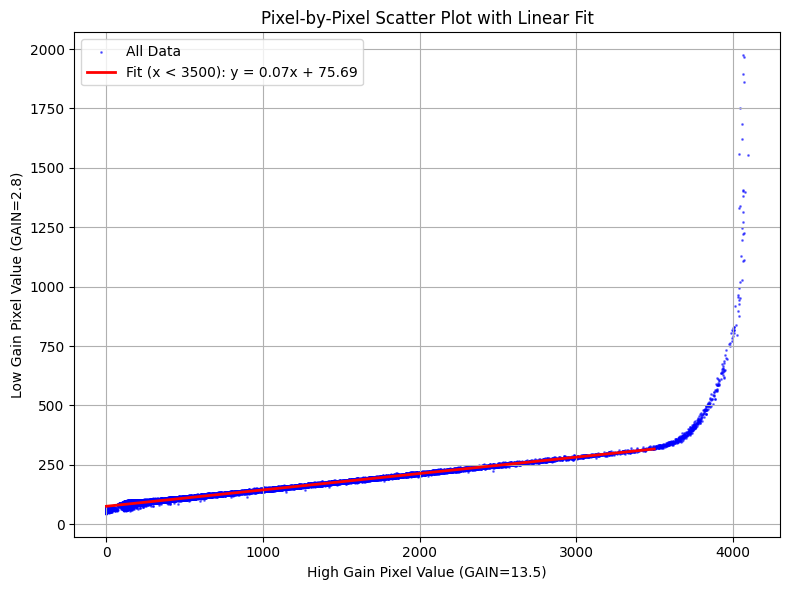

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# Extract gain values
high_data = fits.getdata(high_gain_file)
low_data = fits.getdata(low_gain_file)
high_header = fits.getheader(high_gain_file)
low_header = fits.getheader(low_gain_file)
high_gain_value = high_header.get('GAIN', 'Unknown')
low_gain_value = low_header.get('GAIN', 'Unknown')

# Read data from FITS files
high_data = fits.getdata(high_gain_file)
low_data = fits.getdata(low_gain_file)

# Flatten the arrays
high_flat = high_data.flatten()
low_flat = low_data.flatten()

# Filter out invalid values (e.g., NaNs, infs)
mask = np.isfinite(high_flat) & np.isfinite(low_flat)
high_valid = high_flat[mask]
low_valid = low_flat[mask]

# Further filter for high gain values < 3500
submask = high_valid < 3500
x_fit = high_valid[submask]
y_fit = low_valid[submask]

# Fit a line: y = m*x + b
coeffs = np.polyfit(x_fit, y_fit, 1)
m, b = coeffs

# Generate fitted line
x_line = np.linspace(np.min(x_fit), np.max(x_fit), 500)
y_line = m * x_line + b

# Scatter plot with fitted line
plt.figure(figsize=(8, 6))
plt.scatter(high_valid, low_valid, s=1, alpha=0.5, color='blue', label='All Data')
plt.plot(x_line, y_line, color='red', linewidth=2, label=f'Fit (x < 3500): y = {m:.2f}x + {b:.2f}')
plt.xlabel(f'High Gain Pixel Value (GAIN={high_gain_value})')
plt.ylabel(f'Low Gain Pixel Value (GAIN={low_gain_value})')
plt.title('Pixel-by-Pixel Scatter Plot with Linear Fit')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
